In [1]:
!pip install tensorflow==2.9.1 tensorflow_datasets==4.6.0

from __future__ import absolute_import, division, print_function, unicode_literals

import sys

import os
import re
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tf.keras.utils.set_random_seed(1234)

print(f"Tensorflow version {tf.__version__}")

Defaulting to user installation because normal site-packages is not writeable


2024-12-13 12:11:10.589570: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Tensorflow version 2.9.1


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU {}".format(tpu.cluster_spec().as_dict()["worker"]))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print(f"REPLICAS: {strategy.num_replicas_in_sync}")

REPLICAS: 1


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence



In [4]:
import pandas as pd
file = pd.read_csv("One_Up_On_Wall_Street_QandA_Full.csv")
questions = []
answers = []
for index, row in file.iterrows():
    questions.append(preprocess_sentence(row["question"]))
    answers.append(preprocess_sentence(row["answer"]))

    

In [5]:
questions[0]

'how does lynch counter the idea that following big investors is a safe strategy ?'

In [6]:
answers[0]

'lynch warns that blindly following others can be risky as individual investors may not fully understand the reasons behind big investors moves'

In [7]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

print(f"Tokenized sample question: {tokenizer.encode(questions[98])}")

Tokenized sample question: [11, 6, 1, 426, 5, 65, 3, 178, 690, 2]


In [8]:
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 40

# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding="post"
    )

    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "dec_inputs": answers[:, :-1]},
        {"outputs": answers[:, 1:]},
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

2024-12-13 12:11:22.686543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 12:11:23.437280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13622 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [10]:
dataset

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>

In [11]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += mask * -1e9

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [12]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [13]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [14]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [15]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

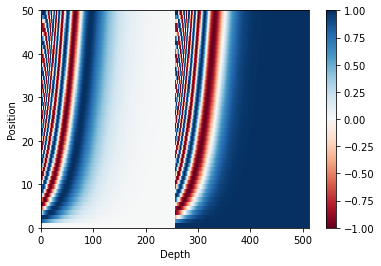

In [16]:
sample_pos_encoding = PositionalEncoding(50, 512, name="sample_pos_encoding")

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

In [17]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [18]:
sample_encoder_layer = encoder_layer(
    units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_encoder_layer"
)

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file="encoder_layer.png", show_shapes=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [19]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [20]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder",
)


In [21]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [22]:
sample_decoder_layer = decoder_layer(
    units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_decoder_layer"
)

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file="decoder_layer.png", show_shapes=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [23]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [24]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder",
)

tf.keras.utils.plot_model(sample_decoder, to_file="decoder.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [25]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [26]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer",
)

tf.keras.utils.plot_model(
    sample_transformer, to_file="transformer.png", show_shapes=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [27]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(
            tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
        )

Text(0.5, 0, 'Train Step')

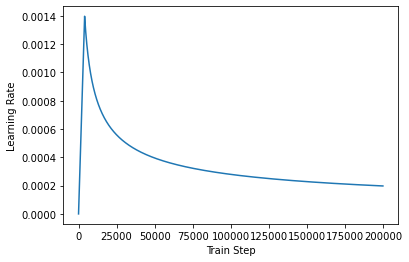

In [29]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [30]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


# initialize and compile model within strategy scope
with strategy.scope():
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    1394432     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [31]:
model.fit(dataset, epochs=830)

Epoch 1/830
3/3 [==============================] - 6s 45ms/step - loss: 4.3729 - accuracy: 1.9279e-04
Epoch 2/830
3/3 [==============================] - 0s 41ms/step - loss: 4.3744 - accuracy: 5.7837e-04
Epoch 3/830
3/3 [==============================] - 0s 32ms/step - loss: 4.3694 - accuracy: 5.7837e-04
Epoch 4/830
3/3 [==============================] - 0s 30ms/step - loss: 4.3633 - accuracy: 5.7837e-04
Epoch 5/830
3/3 [==============================] - 0s 25ms/step - loss: 4.3605 - accuracy: 5.7837e-04
Epoch 6/830
3/3 [==============================] - 0s 25ms/step - loss: 4.3566 - accuracy: 5.7837e-04
Epoch 7/830
3/3 [==============================] - 0s 26ms/step - loss: 4.3430 - accuracy: 0.0015
Epoch 8/830
3/3 [==============================] - 0s 25ms/step - loss: 4.3327 - accuracy: 0.0012
Epoch 9/830
3/3 [==============================] - 0s 24ms/step - loss: 4.3185 - accuracy: 0.0021
Epoch 10/830
3/3 [==============================] - 0s 25ms/step - loss: 4.3028 - accuracy: 0.

In [32]:
filename = "model.h5"
tf.keras.models.save_model(model, filepath=filename, include_optimizer=False)

In [33]:
model = tf.keras.models.load_model(
    filename,
    custom_objects={
        "PositionalEncoding": PositionalEncoding,
        "MultiHeadAttentionLayer": MultiHeadAttentionLayer,
    },
    compile=False,
)

In [34]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )
    return predicted_sentence

In [35]:
predict("Who is peter lynch?")

'lynch notes that while some internet stocks have been highly profitable many have achieved valuations without earnings he advises caution emphasizing the importance of earnings as a measure of a stocks real value'

In [36]:
predict("What is Lynch's ideology for trading?")

'lynch advises investors to look at products they use daily or businesses that they observe growing in popularity this knowledge can often lead to discovering profitable investments early'

In [37]:
predict("What is Lynch's best investments?")

'lynch believes that the best time is when the company is performing well but remains undervalued in the market'

In [38]:
predict("What is his biggest achievement?")

'lynch notes that blue chip stocks can still decline in value especially if they face industry disruptions poor management or economic shifts'

In [39]:
import pandas as pd
file = pd.read_csv("testing.csv")
questions_sentences = []
answers_sentences = []
for index, row in file.iterrows():
    print(row)
    questions_sentences.append(preprocess_sentence(row["question"]))
    answers_sentences.append(preprocess_sentence(row[" answer"]))

    

question    why does lynch describe the importance of pati...
 answer      patience is crucial as significant stock grow...
Name: 0, dtype: object
question       what does lynch mean by “staying in the game”?
 answer      lynch believes that consistency and persisten...
Name: 1, dtype: object
question       how does lynch view corrections in the market?
 answer     lynch views market corrections as normal and b...
Name: 2, dtype: object
question        how does lynch suggest handling bear markets?
 answer     in bear markets lynch advises focusing on the ...
Name: 3, dtype: object
question    what is lynch’s view on bull markets and inves...
 answer     lynch believes that while bull markets create ...
Name: 4, dtype: object
question     how does lynch suggest navigating market cycles?
 answer     he recommends understanding economic cycles an...
Name: 5, dtype: object
question    does lynch believe in timing the market for op...
 answer     no lynch advises against timing the market a

In [40]:
questions_sentences[0]

'why does lynch describe the importance of patience in investing ?'

In [41]:
pred_sentences = []
for question in questions_sentences:
    print(question)
    pred_sentences.append(predict(question))

why does lynch describe the importance of patience in investing ?
what does lynch mean by staying in the game ?
how does lynch view corrections in the market ?
how does lynch suggest handling bear markets ?
what is lynch s view on bull markets and investor caution ?
how does lynch suggest navigating market cycles ?
does lynch believe in timing the market for optimal investment returns ?
how does lynch evaluate healthcare stocks ?
what makes utility stocks attractive in lynch s view ?
why does lynch like retail stocks and what criteria does he use to pick them ?
how does lynch view technology stocks compared to other sectors ?
what sectors does lynch consider recession resistant ?
why does lynch prioritize companies with a simple business model ?
what role does innovation play in lynch s stock picking process ?
how does lynch assess a company s growth potential ?
why does lynch prefer companies with a strong economic moat ?
how does lynch evaluate a company s management team ?
how does 

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score


precision = precision_score(answers_sentences[0:99], pred_sentences, average='weighted', zero_division=0)
recall = recall_score(answers_sentences[:99], pred_sentences, average='weighted', zero_division=0)
f1 = f1_score(answers_sentences[:99], pred_sentences, average='weighted', zero_division=0)


In [43]:
precision

0.5934959349593496

In [44]:
recall

0.6585365853658537

In [45]:
f1

0.6138211382113821

In [46]:
import numpy as np

def compute_accuracy(test_questions, test_answers, tokenizer, model):
    total_tokens = 0
    correct_tokens = 0
    exact_matches = 0

    for question, true_answer in zip(test_questions, test_answers):
        # Tokenize and prepare inputs
        input_tokens = tf.expand_dims(
            START_TOKEN + tokenizer.encode(preprocess_sentence(question)) + END_TOKEN, axis=0
        )

        # Predict output sequence
        output = model.predict([input_tokens, input_tokens[:, :-1]])
        predicted_tokens = tf.argmax(output, axis=-1).numpy()[0]

        # Tokenize ground truth answer
        true_tokens = START_TOKEN + tokenizer.encode(preprocess_sentence(true_answer)) + END_TOKEN

        # Compute token-level accuracy
        total_tokens += len(true_tokens)
        correct_tokens += np.sum(np.array(true_tokens) == np.array(predicted_tokens[:len(true_tokens)]))

        # Compute sequence-level accuracy
        if true_tokens == list(predicted_tokens[:len(true_tokens)]):
            exact_matches += 1

    token_accuracy = correct_tokens / total_tokens
    sequence_accuracy = exact_matches / len(test_questions)

    return token_accuracy, sequence_accuracy

# Example Usage
token_accuracy, sequence_accuracy = compute_accuracy(questions_sentences, pred_sentences, tokenizer, model)
print(f"Token-Level Accuracy: {token_accuracy:.4f}")
print(f"Sequence-Level Accuracy: {sequence_accuracy:.4f}")


1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_151694/2486250296.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_tokens += np.sum(np.array(true_tokens) == np.array(predicted_tokens[:len(true_tokens)]))


1/1 [==============================] - 0s 40ms/step
Token-Level Accuracy: 0.0018
Sequence-Level Accuracy: 0.0000


In [47]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(test_questions, test_answers, tokenizer, model):
    bleu_scores = []

    for question, true_answer in zip(test_questions, test_answers):
        # Tokenize and prepare inputs
        input_tokens = tf.expand_dims(
            START_TOKEN + tokenizer.encode(preprocess_sentence(question)) + END_TOKEN, axis=0
        )

        # Predict output sequence
        output = model.predict([input_tokens, input_tokens[:, :-1]])
        predicted_tokens = tf.argmax(output, axis=-1).numpy()[0]

        # Decode tokens to sentences
        predicted_sentence = tokenizer.decode(
            [i for i in predicted_tokens if i < tokenizer.vocab_size]
        )
        true_sentence = preprocess_sentence(true_answer)

        # Calculate BLEU score
        bleu = sentence_bleu(
            [true_sentence.split()], predicted_sentence.split(),
            smoothing_function=SmoothingFunction().method1
        )
        bleu_scores.append(bleu)

    average_bleu = sum(bleu_scores) / len(bleu_scores)
    return average_bleu

# Example Usage
average_bleu = compute_bleu(questions_sentences, pred_sentences, tokenizer, model)
print(f"Average BLEU Score: {average_bleu:.4f}")


1/1 [==============================] - 0s 35ms/step
Average BLEU Score: 0.0138


In [48]:
!pip install rouge
from rouge import Rouge

def compute_rouge(test_questions, test_answers, tokenizer, model):
    rouge = Rouge()
    predictions, references = [], []

    for question, true_answer in zip(test_questions, test_answers):
        # Tokenize and prepare inputs
        input_tokens = tf.expand_dims(
            START_TOKEN + tokenizer.encode(preprocess_sentence(question)) + END_TOKEN, axis=0
        )

        # Predict output sequence
        output = model.predict([input_tokens, input_tokens[:, :-1]])
        predicted_tokens = tf.argmax(output, axis=-1).numpy()[0]

        # Decode tokens to sentences
        predicted_sentence = tokenizer.decode(
            [i for i in predicted_tokens if i < tokenizer.vocab_size]
        )
        true_sentence = preprocess_sentence(true_answer)

        predictions.append(predicted_sentence)
        references.append(true_sentence)

    # Compute ROUGE scores
    rouge_scores = rouge.get_scores(predictions, references, avg=True)
    return rouge_scores

# Example Usage
rouge_scores = compute_rouge(questions_sentences, answers_sentences, tokenizer, model)
print(f"ROUGE Scores: {rouge_scores}")


Defaulting to user installation because normal site-packages is not writeable
1/1 [==============================] - 0s 45ms/step
ROUGE Scores: {'rouge-1': {'r': 0.19084370487716473, 'p': 0.423992815330692, 'f': 0.25755128018514256}, 'rouge-2': {'r': 0.015513676484532517, 'p': 0.03156636723709894, 'f': 0.02045880877548903}, 'rouge-l': {'r': 0.14586040689252724, 'p': 0.3283586969383239, 'f': 0.1976563018612595}}
